# Crop Recommendation System — Colab Notebook

> **Dataset**: public Kaggle Crop Recommendation dataset

In [76]:
!pip install --quiet xgboost lightgbm shap lime imbalanced-learn scikit-optimize

print('Install step finished. Proceed to run the next cells.')

Install step finished. Proceed to run the next cells.


In [54]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [55]:
import requests
csv_path = '/content/Crop_recommendation.csv'

if not os.path.exists(csv_path):
    print('Downloading dataset from GitHub...')
    url = "https://raw.githubusercontent.com/aakashr02/Crop-Recommendation/main/data/Crop_recommendation.csv"
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        open(csv_path, 'wb').write(r.content)
        print('Downloaded to', csv_path)
    except Exception as e:
        print('Could not download automatically. Please upload the CSV manually to /content/ or mount Google Drive.')
        print('Error:', e)


df = pd.read_csv(csv_path)
print('Dataset loaded. Shape:', df.shape)
df.head()

Dataset loaded. Shape: (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


## EDA

In [75]:
# Basic info & sanity checks
print('Columns:', df.columns.tolist())
print('\nInfo:')
display(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nValue counts for target label (sample):')
display(df['label'].value_counts().head(30))

print('\ndescriptive statistics:')
display(df.describe().T)

Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


None


Missing values per column:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Value counts for target label (sample):


,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100



descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117


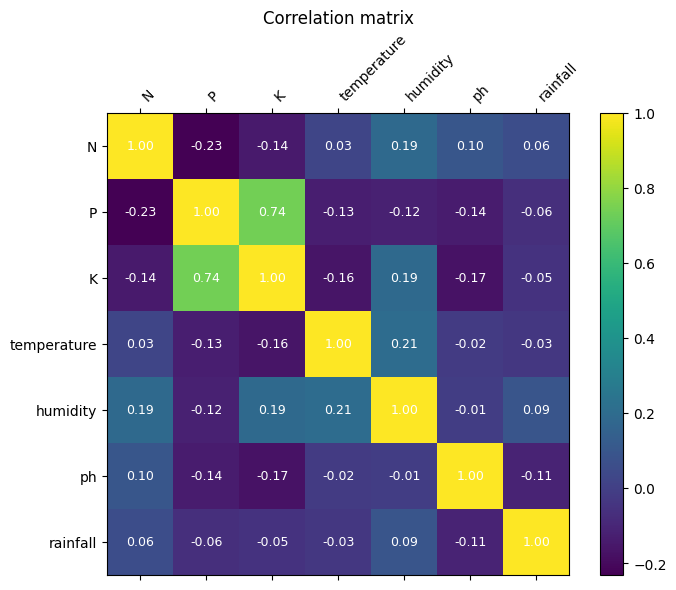

In [58]:
# correlation matrix
num = df[['N','P','K','temperature','humidity','ph','rainfall']].corr()
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(num, cmap='viridis')
fig.colorbar(cax)
ax.set_xticks(range(len(num.columns)))
ax.set_yticks(range(len(num.columns)))
ax.set_xticklabels(num.columns, rotation=45, ha='left')
ax.set_yticklabels(num.columns)


for (i, j), val in np.ndenumerate(num.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white', fontsize=9)
plt.title('Correlation matrix')
plt.show()

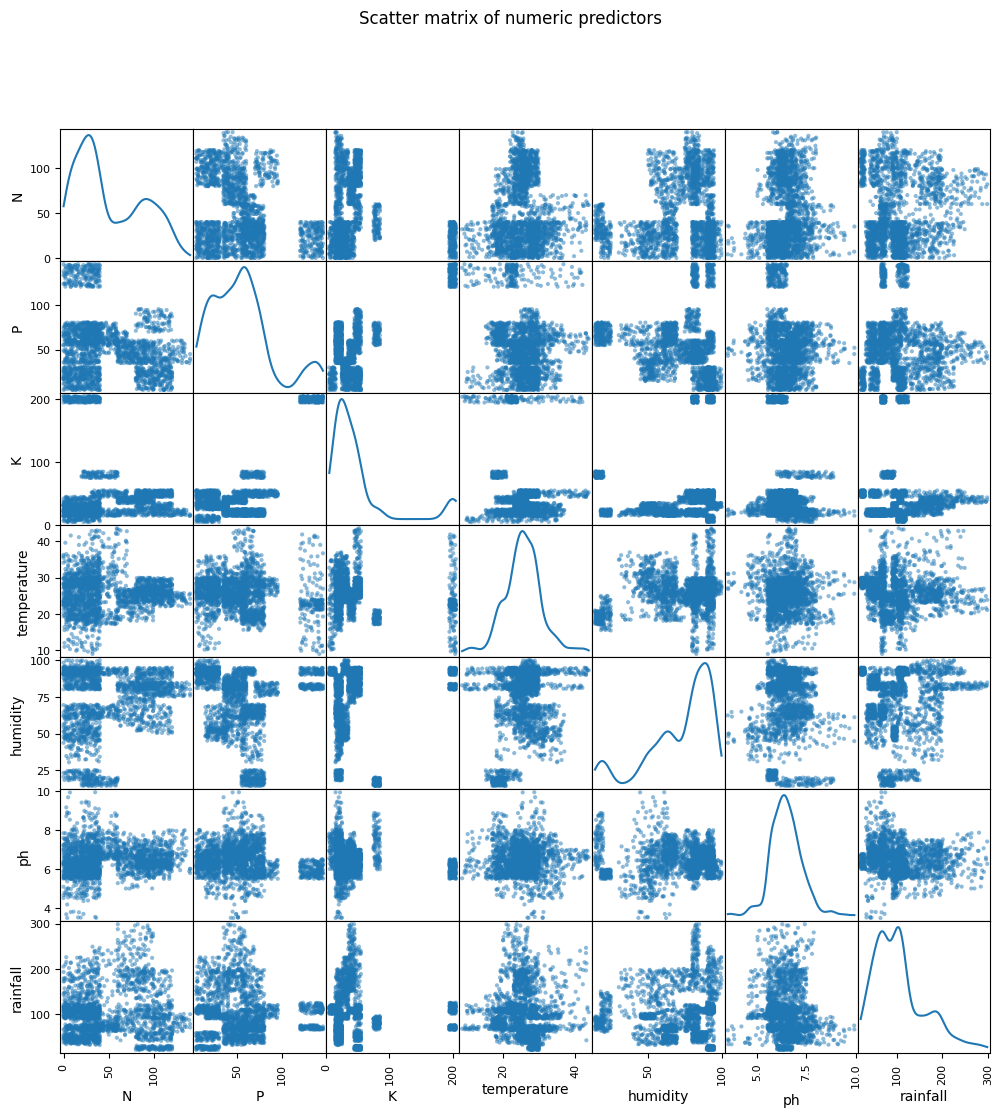

In [59]:
# pair plot
scatter_matrix(df[num_cols], figsize=(12,12), diagonal='kde')
plt.suptitle('Scatter matrix of numeric predictors')
plt.show()

In [60]:
# distribution of classes.
label_counts = df['label'].value_counts().sort_values(ascending=False)
print('Total classes:', label_counts.shape[0])
display(label_counts)

Total classes: 22


,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


## Scale & standardizing and encoding

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = df[['N','P','K','temperature','humidity','ph','rainfall']].copy()
y = df['label'].copy()

# Scale & standardizing and encoding
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


le = LabelEncoder()
y_enc = le.fit_transform(y)

## train_test_split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('Preprocessing complete.')

X_train shape: (1760, 7)
X_test shape: (440, 7)
y_train shape: (1760,)
y_test shape: (440,)
Preprocessing complete.


## MODELS TRAINING

In [63]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_eval_model(model, X_tr, y_tr, X_te, y_te, name='Model'):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='macro')

    print(f'--- {name} ---')
    print('Accuracy:', acc)
    print('F1 macro:', f1)
    # print('\nClassification report:')
    # print(classification_report(y_te, y_pred, target_names=le.classes_))

    return {'model': name, 'accuracy': acc, 'f1_macro': f1}

In [64]:
#Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
res_lr = train_eval_model(log_reg, X_train, y_train, X_test, y_test, 'LogisticRegression')

--- LogisticRegression ---
Accuracy: 0.9727272727272728
F1 macro: 0.9724640256149183


In [65]:
#KNN
knn = KNeighborsClassifier(n_neighbors=7)
res_knn = train_eval_model(knn, X_train, y_train, X_test, y_test, 'KNN')

--- KNN ---
Accuracy: 0.9704545454545455
F1 macro: 0.9701916027706396


In [66]:
#SVC
svc = SVC(probability=True, kernel='rbf')
res_svc = train_eval_model(svc, X_train, y_train, X_test, y_test, 'SVC')

--- SVC ---
Accuracy: 0.9840909090909091
F1 macro: 0.9840381050638686


In [67]:
#Random-Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
res_rf = train_eval_model(rf, X_train, y_train, X_test, y_test, 'RandomForest')

--- RandomForest ---
Accuracy: 0.9954545454545455
F1 macro: 0.9954517027687758


In [68]:
# Collect results into a DataFrame for comparison
results = [res_lr, res_knn, res_svc, res_rf]
res_df = pd.DataFrame(results)[['model', 'accuracy', 'f1_macro']].sort_values('f1_macro', ascending=False)
display(res_df)

,model,accuracy,f1_macro
3,RandomForest,0.995455,0.995452
2,SVC,0.984091,0.984038
0,LogisticRegression,0.972727,0.972464
1,KNN,0.970455,0.970192


## XGBoost & LightGBM training

In [69]:
import xgboost as xgb
import lightgbm as lgb
import pandas as pd

final_results = []

# XGBoost

xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=1
)
res_xgb = train_eval_model(xgb_clf, X_train, y_train, X_test, y_test, 'XGBoost')
final_results.append(res_xgb)

--- XGBoost ---
Accuracy: 0.9931818181818182
F1 macro: 0.9931162119865586


## LightGBM

In [70]:
lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=1)
res_lgb = train_eval_model(lgb_clf, X_train, y_train, X_test, y_test, 'LightGBM')
final_results.append(res_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 7
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] 

In [71]:
if 'res_df' in globals():
    comp = res_df.copy()
    new_rows = [{'model': r['model'], 'accuracy': r['accuracy'], 'f1_macro': r['f1_macro']}
                for r in final_results]
    if new_rows:
        comp = pd.concat([comp, pd.DataFrame(new_rows)], ignore_index=True)
    display(comp.sort_values('f1_macro', ascending=False))
else:
    if final_results:
        comp = pd.DataFrame(final_results)[['model', 'accuracy', 'f1_macro']]
        display(comp.sort_values('f1_macro', ascending=False))
    else:
        print('No models evaluated; final_results is empty.')


,model,accuracy,f1_macro
0,RandomForest,0.995455,0.995452
4,XGBoost,0.993182,0.993116
5,LightGBM,0.988636,0.988569
1,SVC,0.984091,0.984038
2,LogisticRegression,0.972727,0.972464
3,KNN,0.970455,0.970192


### # Saving the Final choosen model (if best_xgb == available, else best_lgb, else RandomForest)

In [73]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
model_to_save = rf


out = {'model': model_to_save, 'scaler': scaler, 'label_encoder': le}
with open('/content/final_crop_model.pkl', 'wb') as f:
    pickle.dump(out, f)
print('Saved model to /content/final_crop_model.pkl')

Saved model to /content/final_crop_model.pkl


### A Demo-Demo of laoding saved model into the env and running a demo prediciton with a random value.

In [74]:
import pickle
with open('/content/final_crop_model.pkl','rb') as f:
    saved = pickle.load(f)

model = saved['model']
scaler = saved['scaler']
le = saved['label_encoder']

# input (n, p, k, temperature, humidity, ph, rainfall)
example = np.array([[90, 42, 43, 25, 80, 6.5, 200]])
example_scaled = scaler.transform(example)
pred = model.predict(example_scaled)
print('Predicted label index:', pred[0], '-> crop:', le.inverse_transform(pred)[0])

Predicted label index: 20 -> crop: rice
